In [1]:
import os
import cv2
import numpy as np
import shutil
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
import random

In [2]:
# --- CONFIGURATION ---
INPUT_DIR = "../content/dataset"
OUTPUT_DIR = "../content/processed_data"
TARGET_SIZE = (224, 224)
TARGET_COUNT = 2000  # Target number of images per class
CLASSES = ["Hemorrhagic", "Ischemic", "Tumor"]
# ---------------------

In [3]:
augment_pipeline = transforms.Compose([
    transforms.RandomRotation(degrees=10),      # Reduced rotation to avoid cutting corners
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)), # Gentler shifts
])

In [4]:
def extract_roi_and_mask(image):
    """
    Smarter ROI extraction that prevents 'Zooming on Noise'.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # GUARD 1: Use Otsu's Thresholding (Auto-adapts to dark images)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return image 

    # Find largest contour
    c = max(contours, key=cv2.contourArea)
    
    # GUARD 2: Area Check [Keep this]
    img_area = image.shape[0] * image.shape[1]
    contour_area = cv2.contourArea(c)
    if contour_area < (0.02 * img_area):
        return image 

    # Masking [Keep this]
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [c], -1, 255, -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    # --- UPDATED CROPPING WITH PADDING ---
    x, y, w, h = cv2.boundingRect(c)
    
    # Add 20 pixels of padding around the brain
    pad = 20
    
    # Ensure we don't go out of image bounds (indices can't be negative)
    x_new = max(0, x - pad)
    y_new = max(0, y - pad)
    w_new = min(image.shape[1] - x_new, w + 2*pad)
    h_new = min(image.shape[0] - y_new, h + 2*pad)
    
    roi = masked_image[y_new:y_new+h_new, x_new:x_new+w_new]
    # -------------------------------------
    
    return roi

In [5]:
def normalize_and_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # Lowered clipLimit slightly to reduce noise boost
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    final_norm = cv2.normalize(final, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return final_norm

In [6]:
def preprocess_and_balance_pytorch():
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)
    

    for cls in CLASSES:
        print(f"\nProcessing Class: {cls}...")
        os.makedirs(os.path.join(OUTPUT_DIR, cls), exist_ok=True)
        
        src_path = os.path.join(INPUT_DIR, cls)
        images = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        
        current_count = len(images)
        if current_count == 0: continue
        
        aug_multiplier = 1
        if current_count < TARGET_COUNT: 
            aug_multiplier = int(TARGET_COUNT / current_count)

        save_idx = 0
        
        for img_name in tqdm(images):
            img_path = os.path.join(src_path, img_name)
            img = cv2.imread(img_path)
            if img is None: continue

            # A. Clean & Enhance
            img_roi = extract_roi_and_mask(img)
            img_resized = cv2.resize(img_roi, TARGET_SIZE)
            img_processed = normalize_and_clahe(img_resized)

            # B. Save Real
            base_save_name = os.path.join(OUTPUT_DIR, cls, f"real_{save_idx}.jpg")
            cv2.imwrite(base_save_name, img_processed)
            save_idx += 1

            # C. Augment
            if aug_multiplier > 1:
                img_rgb = cv2.cvtColor(img_processed, cv2.COLOR_BGR2RGB)
                pil_img = Image.fromarray(img_rgb)
                
                for i in range(aug_multiplier - 1): 
                    aug_pil = augment_pipeline(pil_img)
                    aug_img = cv2.cvtColor(np.array(aug_pil), cv2.COLOR_RGB2BGR)
                    
                    aug_name = os.path.join(OUTPUT_DIR, cls, f"aug_{save_idx}_{i}.jpg")
                    cv2.imwrite(aug_name, aug_img)
                    
                save_idx += 1

    print(f"\nProcessing Complete. Data ready at: {OUTPUT_DIR}")

In [7]:
# Run the pipeline
preprocess_and_balance_pytorch()


Processing Class: Hemorrhagic...


100%|██████████| 186/186 [00:05<00:00, 33.50it/s]



Processing Class: Ischemic...


100%|██████████| 171/171 [00:05<00:00, 33.69it/s]



Processing Class: Tumor...


100%|██████████| 2475/2475 [00:28<00:00, 86.00it/s]


Processing Complete. Data ready at: ../content/processed_data


C:\Users\yusuf\AppData\Local\Temp\ipykernel_14580\2747130673.py:48: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  ax_hist.hist(sample_proc.ravel(), 256, [0, 256], color='black', alpha=0.7)


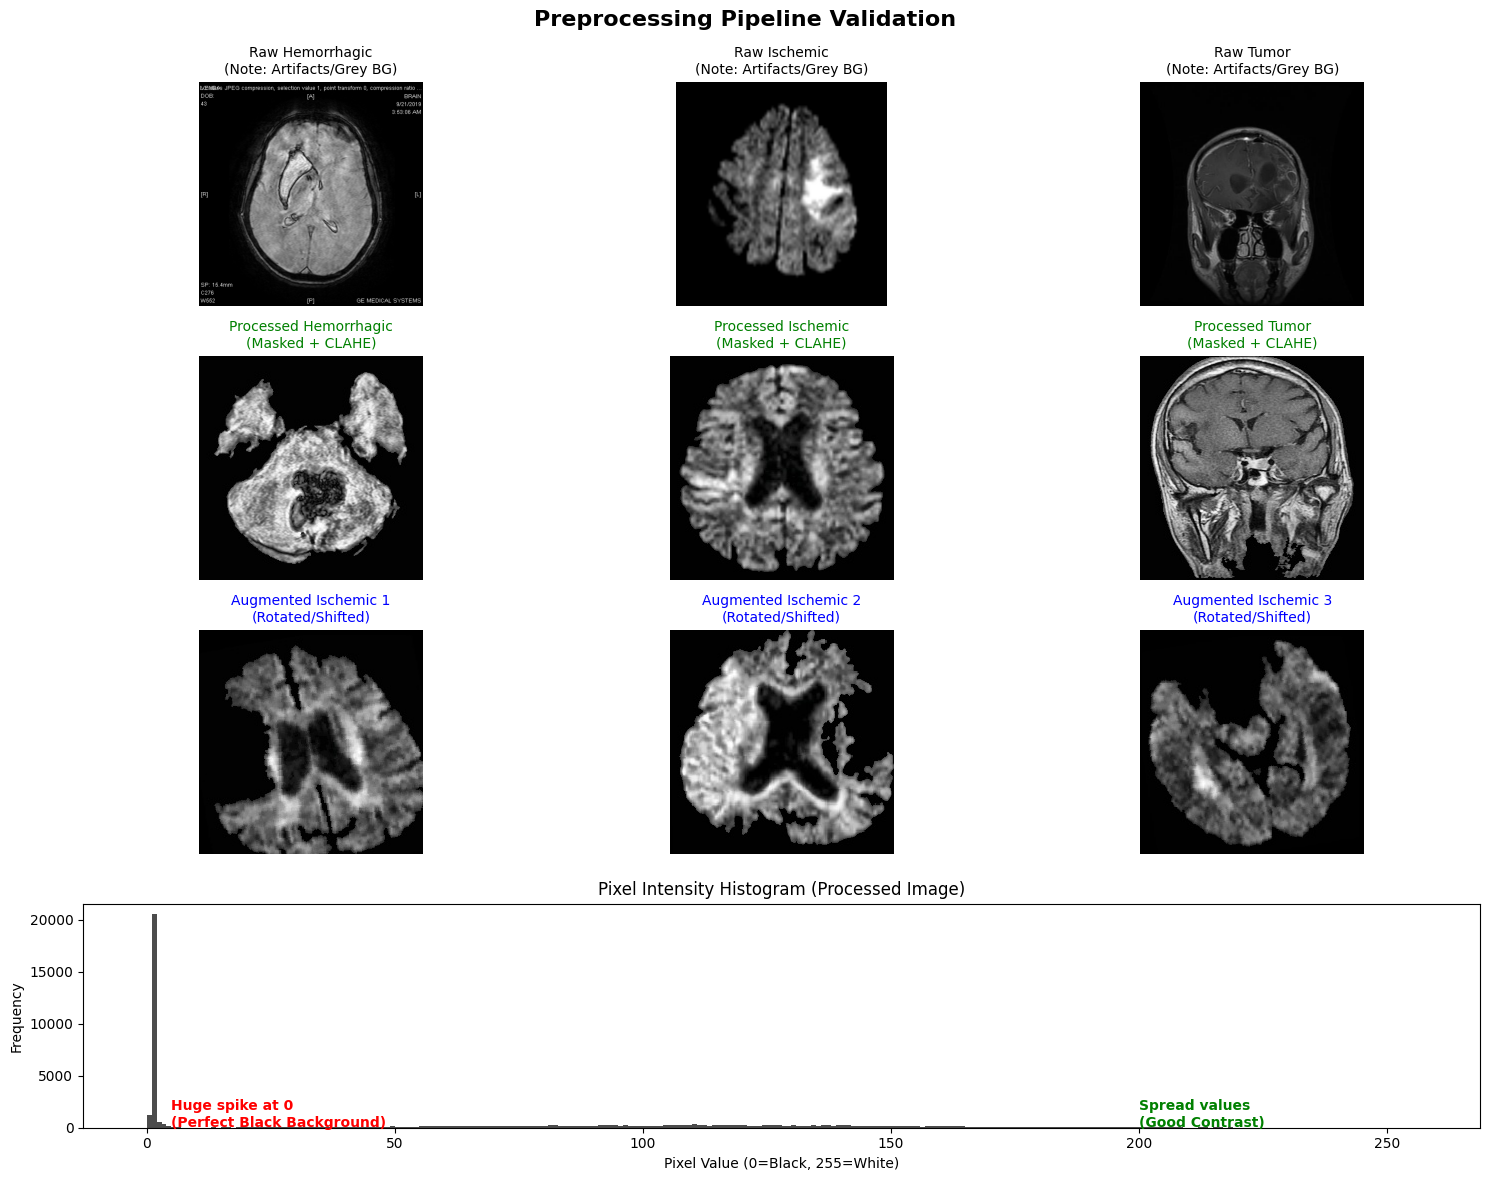

In [8]:
def visualize_preprocessing_results():
    fig = plt.figure(figsize=(15, 12))
    plt.suptitle("Preprocessing Pipeline Validation", fontsize=16, fontweight='bold')

    # --- ROW 1: Raw vs Processed (Random Samples) ---
    # Since we renamed files, we pick random ones from both folders to compare "Style"
    for i, cls in enumerate(CLASSES):
        # Get random raw image
        raw_files = glob(os.path.join(INPUT_DIR, cls, "*"))
        raw_img = cv2.imread(random.choice(raw_files))
        raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
        
        # Get random PROCESSED image (Real, not augmented)
        proc_files = glob(os.path.join(OUTPUT_DIR, cls, "real_*.jpg"))
        proc_img = cv2.imread(random.choice(proc_files))
        proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)

        # Plot Raw
        ax1 = plt.subplot(4, 3, i + 1)
        ax1.imshow(raw_img)
        ax1.set_title(f"Raw {cls}\n(Note: Artifacts/Grey BG)", fontsize=10)
        ax1.axis('off')

        # Plot Processed
        ax2 = plt.subplot(4, 3, i + 4)
        ax2.imshow(proc_img)
        ax2.set_title(f"Processed {cls}\n(Masked + CLAHE)", fontsize=10, color='green')
        ax2.axis('off')

    # --- ROW 3: Augmentation Check (Show Ischemic Augmentations) ---
    # We want to make sure the rotations aren't too extreme
    aug_files = glob(os.path.join(OUTPUT_DIR, "Ischemic", "aug_*.jpg"))
    if aug_files:
        for j in range(3):
            aug_img = cv2.imread(random.choice(aug_files))
            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
            
            ax = plt.subplot(4, 3, j + 7)
            ax.imshow(aug_img)
            ax.set_title(f"Augmented Ischemic {j+1}\n(Rotated/Shifted)", fontsize=10, color='blue')
            ax.axis('off')

    # --- ROW 4: Histogram Analysis (Pixel Intensity) ---
    # This proves the background is pure black (0) and contrast is stretched
    sample_proc = cv2.imread(random.choice(glob(os.path.join(OUTPUT_DIR, "Ischemic", "real_*.jpg"))), 0)
    
    ax_hist = plt.subplot(4, 1, 4)
    ax_hist.hist(sample_proc.ravel(), 256, [0, 256], color='black', alpha=0.7)
    ax_hist.set_title("Pixel Intensity Histogram (Processed Image)", fontsize=12)
    ax_hist.set_xlabel("Pixel Value (0=Black, 255=White)")
    ax_hist.set_ylabel("Frequency")
    # Add text annotation
    ax_hist.text(5, 100, "Huge spike at 0\n(Perfect Black Background)", color='red', fontweight='bold')
    ax_hist.text(200, 100, "Spread values\n(Good Contrast)", color='green', fontweight='bold')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

visualize_preprocessing_results()

PREPROCESSED DATA CLASS DISTRIBUTION

Hemorrhagic:
  Total Images: 1860
  Real Images: 186
  Augmented Images: 1674

Ischemic:
  Total Images: 1881
  Real Images: 171
  Augmented Images: 1710

Tumor:
  Total Images: 2475
  Real Images: 2475
  Augmented Images: 0

TOTAL DATASET SIZE: 6216 images


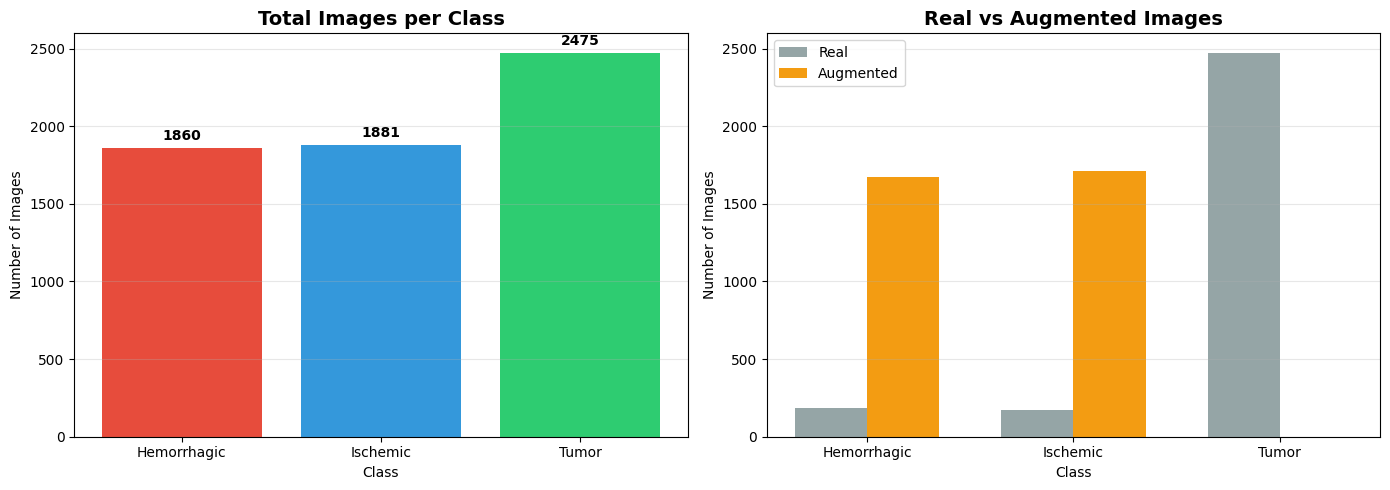

In [9]:
def assess_class_distribution():
    """
    Counts images in each class folder and visualizes the distribution.
    """
    print("="*60)
    print("PREPROCESSED DATA CLASS DISTRIBUTION")
    print("="*60)
    
    class_counts = {}
    real_counts = {}
    aug_counts = {}
    
    for cls in CLASSES:
        cls_path = os.path.join(OUTPUT_DIR, cls)
        
        if not os.path.exists(cls_path):
            print(f"WARNING: {cls} folder not found!")
            continue
        
        # Count all images
        all_images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        class_counts[cls] = len(all_images)
        
        # Count real vs augmented
        real_images = [f for f in all_images if f.startswith('real_')]
        aug_images = [f for f in all_images if f.startswith('aug_')]
        
        real_counts[cls] = len(real_images)
        aug_counts[cls] = len(aug_images)
        
        print(f"\n{cls}:")
        print(f"  Total Images: {class_counts[cls]}")
        print(f"  Real Images: {real_counts[cls]}")
        print(f"  Augmented Images: {aug_counts[cls]}")
    
    print("\n" + "="*60)
    print(f"TOTAL DATASET SIZE: {sum(class_counts.values())} images")
    print("="*60)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Total counts
    axes[0].bar(class_counts.keys(), class_counts.values(), color=['#e74c3c', '#3498db', '#2ecc71'])
    axes[0].set_title('Total Images per Class', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Images')
    axes[0].set_xlabel('Class')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, (cls, count) in enumerate(class_counts.items()):
        axes[0].text(i, count + 50, str(count), ha='center', fontweight='bold')
    
    # Plot 2: Real vs Augmented breakdown
    x = np.arange(len(CLASSES))
    width = 0.35
    
    axes[1].bar(x - width/2, [real_counts[cls] for cls in CLASSES], width, label='Real', color='#95a5a6')
    axes[1].bar(x + width/2, [aug_counts[cls] for cls in CLASSES], width, label='Augmented', color='#f39c12')
    
    axes[1].set_title('Real vs Augmented Images', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Number of Images')
    axes[1].set_xlabel('Class')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(CLASSES)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return class_counts, real_counts, aug_counts

# Run assessment
class_counts, real_counts, aug_counts = assess_class_distribution()